In [61]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool
import pickle

file_path = 'dataset_prepared_12.xlsx'
dataset = pd.read_excel(file_path)

# Separate features and target
X = dataset.drop(columns=['status'])
y = dataset['status']



In [40]:
model = pickle.load(open('model.pkl', 'rb'))

In [50]:
# Create a CatBoost Pool for the test data
test_pool = Pool(X, y)

feature_importance = model.get_feature_importance(
    data=test_pool,  # Compute importance on test data
    type='PredictionValuesChange',  # Default importance type
    prettified=True  # Returns a DataFrame with feature names
)

# I have too many calculated and encoded categorical features, so I need to do some filtering and renaming
# to make the result readable:
patterns_to_exclude = ['position', 'city', 'field', 'region', 'industry']  # Add more as needed
regex_pattern = '|'.join(patterns_to_exclude)
feature_importance = feature_importance[~feature_importance['Feature Id'].str.contains(regex_pattern, case=False, na=False)]# I have too many categorical encoded features, so I'll try to aggregate them to make the feature importance readable:
feature_importance['Feature Id'] = feature_importance['Feature Id'].replace({
    'log_seniority': 'seniority_0',
    'vacations_by_city': 'number of available vacations',
    'unused_vacation_per_experience': 'unused vacations',
    'vacation_days_shortterm': 'unused vacations_0',
    'vacation_days_deriv': 'unused vacations (dynamic)',
    'department': 'job category'
})
feature_importance['Feature Id'] = feature_importance['Feature Id'].str.replace(
    r'^salary_',
    'income_0_',
    regex=True
)
feature_importance['Feature Id'] = feature_importance['Feature Id'].str.replace(
    r'^department',
    'job category_',
    regex=True
)
feature_importance = feature_importance[~feature_importance['Feature Id'].str.contains('department', case=False, na=False)]# I have too many categorical encoded features, so I'll try to aggregate them to make the feature importance readable:

feature_importance['BaseFeature'] = feature_importance['Feature Id'].str.split('_').str[0]

aggregated_importance = feature_importance.groupby('BaseFeature')['Importances'].mean().reset_index()
aggregated_importance = aggregated_importance.sort_values('Importances', ascending=False)

print(aggregated_importance)

                  BaseFeature  Importances
9  unused vacations (dynamic)     8.697803
2                         age     8.501320
8            unused vacations     7.372276
7                   seniority     4.859258
5                      income     2.322517
4                      gender     1.276998
1                 absenteeism     0.889049
0                    absences     0.769184
6                job category     0.147200
3                 citizenship     0.121209


In [70]:
# Now I want to extract feature importance for each job category separately:
dept_columns = [col for col in X.columns if col.startswith('department_')]

# The feature is one-hot encoded, so we need some additional actions to group by it:
X['active_department'] = X[dept_columns].idxmax(axis=1).str.replace('department_', '')
dataset['active_department'] = dataset[dept_columns].idxmax(axis=1).str.replace('department_', '')

assert (X[dept_columns].sum(axis=1) == 1).all(), "Some rows have multiple/no departments!"

for dept in X['active_department'].unique():
    # Filter rows for this job category
    dept_mask = X['active_department'] == dept
    dept_data = X[dept_mask].drop(columns=['active_department'])
    
    # Create Pool and compute importance
    dept_pool = Pool(
        data=dept_data, 
        label=y[dept_mask] if y is not None else None
    )
    feature_importance = model.get_feature_importance(
        data=dept_pool,
        type='PredictionValuesChange',  # or 'ShapValues'
        prettified=True
    )
    
    # I have too many calculated and encoded categorical features, so I need to do some filtering and renaming
    # to make the result readable:
    patterns_to_exclude = ['position', 'city', 'field', 'region', 'industry']
    regex_pattern = '|'.join(patterns_to_exclude)
    feature_importance = feature_importance[~feature_importance['Feature Id'].str.contains(regex_pattern, case=False, na=False)]# I have too many categorical encoded features, so I'll try to aggregate them to make the feature importance readable:
    feature_importance['Feature Id'] = feature_importance['Feature Id'].replace({
        'log_seniority': 'seniority_0',
        'vacations_by_city': 'number of available vacations',
        'unused_vacation_per_experience': 'unused vacations',
        'vacation_days_shortterm': 'unused vacations_0',
        'vacation_days_deriv': 'unused vacations (dynamic)',
        'department': 'job category'
    })
    feature_importance['Feature Id'] = feature_importance['Feature Id'].str.replace(
        r'^salary_',
        'income_0_',
        regex=True
    )
    feature_importance['Feature Id'] = feature_importance['Feature Id'].str.replace(
        r'^department',
        'job category_',
        regex=True
    )
    feature_importance = feature_importance[~feature_importance['Feature Id'].str.contains('department', case=False, na=False)]# I have too many categorical encoded features, so I'll try to aggregate them to make the feature importance readable:

    feature_importance['BaseFeature'] = feature_importance['Feature Id'].str.split('_').str[0]

    aggregated_importance = feature_importance.groupby('BaseFeature')['Importances'].mean().reset_index()
    aggregated_importance = aggregated_importance.sort_values('Importances', ascending=False)


    dept_feature_importance[dept] = aggregated_importance

    # Print top features for this job category
    print(f"\n--- {dept} ---")
    print(aggregated_importance.sort_values('Importances', ascending=False).head())


--- производство ---
                  BaseFeature  Importances
9  unused vacations (dynamic)    10.000080
2                         age     9.275116
8            unused vacations     7.518111
7                   seniority     5.009145
5                      income     2.544016

--- управление ---
                  BaseFeature  Importances
9  unused vacations (dynamic)     9.957972
8            unused vacations     8.674313
2                         age     8.503229
7                   seniority     5.137219
5                      income     2.080256

--- офис ---
                  BaseFeature  Importances
9  unused vacations (dynamic)     9.206784
8            unused vacations     8.937591
2                         age     7.957989
7                   seniority     5.245900
5                      income     2.546441

--- сотрудник склада ---
                  BaseFeature  Importances
2                         age    10.990876
9  unused vacations (dynamic)     9.319854
8            un

In [71]:
# Get dismission probabilities
result = {'personal code': [], 'probability of leaving': []}
for n, row in dataset.iterrows():
    code = row['code']
    sample = dataset.loc[dataset['code']==code]

    feat = sample.drop(columns=['status'])
    trg = sample['status']
    
    pred = model.predict_proba(feat)
    result['personal code'].append(code)
    result['probability of leaving'].append(np.round(pred[0][1], 2))

result = pd.DataFrame(result)
print(result.sort_values('probability of leaving', ascending=False).head())
#result.to_excel('Dismission_probabilities.xlsx', index=False)


      personal code  probability of leaving
388           388.0                     1.0
694           694.0                     1.0
89             89.0                     1.0
1207         1207.0                     1.0
1163         1163.0                     1.0


In [77]:
# Now get the aggregated probabilities of dismissal per job category:
pred_by_job_category = {'job category': [], 'avg. probability of leaving': []}

for dept in X['active_department'].unique():
    dept_mask = X['active_department'] == dept
    dept_data = X[dept_mask].drop(columns=['active_department'])
    average_prediction = 0.
    for n, row in dept_data.iterrows():
        code = row['code']
        sample = dept_data.loc[dept_data['code']==code]

        pred = model.predict_proba(dept_data)
        average_prediction += pred[0][1]
    average_prediction /= n
    
    pred_by_job_category['job category'].append(dept)
    pred_by_job_category['avg. probability of leaving'].append(np.round(pred[0][1], 2))
pred_by_job_category = pd.DataFrame(pred_by_job_category)
print(pred_by_job_category.sort_values('avg. probability of leaving', ascending=False).head())
    

       job category  avg. probability of leaving
2              офис                         0.98
0      производство                         0.81
6             Other                         0.77
5           инженер                         0.62
3  сотрудник склада                         0.57


In [57]:
#Calculate employee's business value and financial valus:
def calculate_k(seniority):
    if seniority < 5:
        return 0.5
    elif 5 <= seniority < 7:
        return 1.0
    elif 7 <= seniority < 10:
        return 1.5
    else:
        return 2.0

dataset['year_income'] = dataset['income_shortterm'] * 12
dataset['K'] = dataset['seniority'].apply(calculate_k)
dataset['business_value'] = dataset['year_income'] * dataset['K']

result = result.rename(columns={'personal code': 'code'})
merged = pd.merge(dataset, result, on='code')
merged['financial_value'] = merged['business_value'] * merged['probability of leaving']
print(merged[['code', 'financial_value']])


      code  financial_value
0        0    399465.801397
1        1    252950.501049
2        2    415313.973336
3        3     67119.977328
4        4    391411.586515
...    ...              ...
1322  1322     12802.722152
1323  1323     21922.539356
1324  1324     96901.021895
1325  1325    199025.079100
1326  1326     71928.782242

[1327 rows x 2 columns]


In [91]:
# Calculate average company seniority per job category
avg_seniority_by_dept = X.groupby('active_department')['seniority'].mean().round(2).sort_values(ascending=False)
print(avg_seniority_by_dept)

active_department
IT                                      9.20
Other                                   6.39
производство высококвалифицированное    6.34
управление                              5.88
водитель                                4.74
медецинский персонал                    4.45
логистика                               4.07
офис                                    3.05
производство                            2.83
сотрудник склада                        2.77
инженер                                 1.78
Name: seniority, dtype: float64


In [89]:
# Calculate average age per job category
avg_age_by_dept = X.groupby('active_department')['age'].mean().round(2).sort_values(ascending=False)
print(avg_age_by_dept)

active_department
медецинский персонал                    64.00
производство высококвалифицированное    48.33
Other                                   46.61
сотрудник склада                        44.99
водитель                                44.61
IT                                      43.42
производство                            40.92
управление                              39.26
офис                                    36.52
инженер                                 35.58
логистика                               34.89
Name: age, dtype: float64


/tmp/ipykernel_32838/3113411858.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset.groupby(['active_department', 'age_group'])
/tmp/ipykernel_32838/3113411858.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset.groupby(['active_department', 'age_group'])


  active_department age_group  dismissal_rate
0                IT     36-45        0.000000
1                IT       45+        0.000000
2             Other     18-25      100.000000
3             Other     26-35       25.000000
4             Other     36-45       16.666667


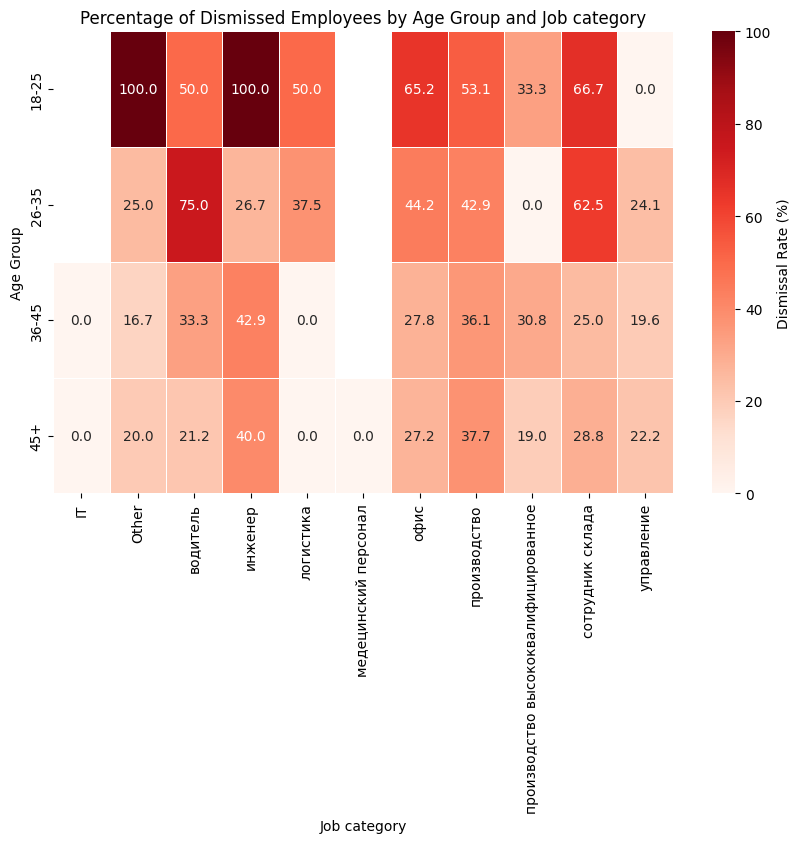

In [103]:
# Age of dismissed:
age_bins = [18, 25, 35, 45, 120]
age_labels = ['18-25', '26-35', '36-45', '45+']

dataset['age_group'] = pd.cut(dataset['age'], bins=age_bins, labels=age_labels, right=False)

# 2. Calculate dismissal rates per (job category, age_group)
dismissal_rates = (
    dataset.groupby(['active_department', 'age_group'])
    .apply(lambda x: (x['status'].sum() / len(x)) * 100)
    .reset_index(name='dismissal_rate')
)

print(dismissal_rates.head())

# Visualize it:
heatmap_data = dismissal_rates.pivot(
    index="age_group", 
    columns="active_department", 
    values="dismissal_rate"
)

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap="Reds",
    linewidths=0.5,
    cbar_kws={'label': 'Dismissal Rate (%)'}
)
plt.title("Percentage of Dismissed Employees by Age Group and Job category")
plt.xlabel("Job category")
plt.ylabel("Age Group")
plt.show()

In [90]:
# Calculate churn per job category
dataset = pd.concat([X, y], axis=1)
avg_seniority_by_dept = dataset.groupby('active_department')['status'].mean().round(2).sort_values(ascending=False)
print(avg_seniority_by_dept)

active_department
офис                                    0.40
производство                            0.40
инженер                                 0.36
сотрудник склада                        0.35
водитель                                0.34
логистика                               0.27
Other                                   0.22
производство высококвалифицированное    0.22
управление                              0.21
IT                                      0.00
медецинский персонал                    0.00
Name: status, dtype: float64


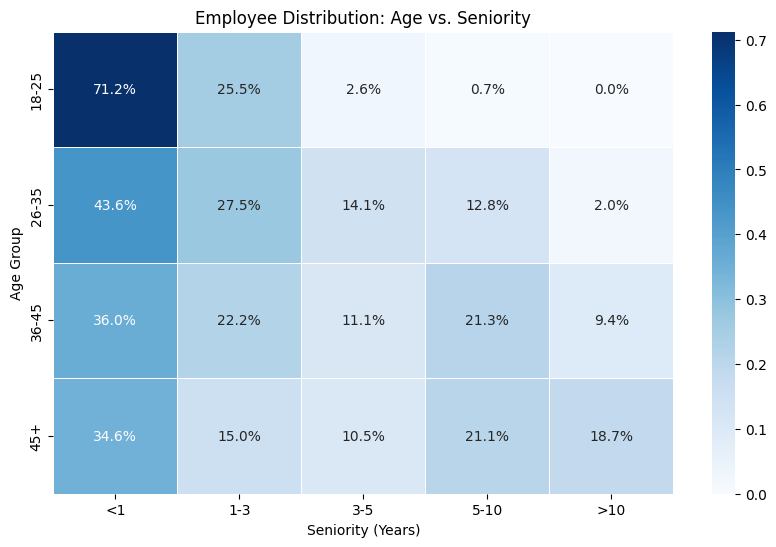

In [93]:
# Company seniority vs Age
age_bins = [18, 25, 35, 45, 120]
age_labels = ['18-25', '26-35', '36-45', '45+']

seniority_bins = [0, 1, 3, 5, 10, 100]
seniority_labels = ['<1', '1-3', '3-5', '5-10', '>10']

X['age_group'] = pd.cut(X['age'], bins=age_bins, labels=age_labels, right=False)
X['seniority_group'] = pd.cut(X['seniority'], bins=seniority_bins, labels=seniority_labels, right=False)

cross_tab = pd.crosstab(
    index=X['age_group'],
    columns=X['seniority_group'],
    normalize='index'  # Use 'all' for total %, or remove for counts
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    cross_tab, 
    annot=True, 
    fmt='.1%',  # Format as percentages (use '.0f' for counts)
    cmap='Blues',
    linewidths=.5
)
plt.title('Employee Distribution: Age vs. Seniority')
plt.xlabel('Seniority (Years)')
plt.ylabel('Age Group')
plt.show()

/tmp/ipykernel_32838/2786407275.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_data = X.groupby(['active_department', 'seniority_bin'])['income_shortterm'].mean().reset_index()


1
3


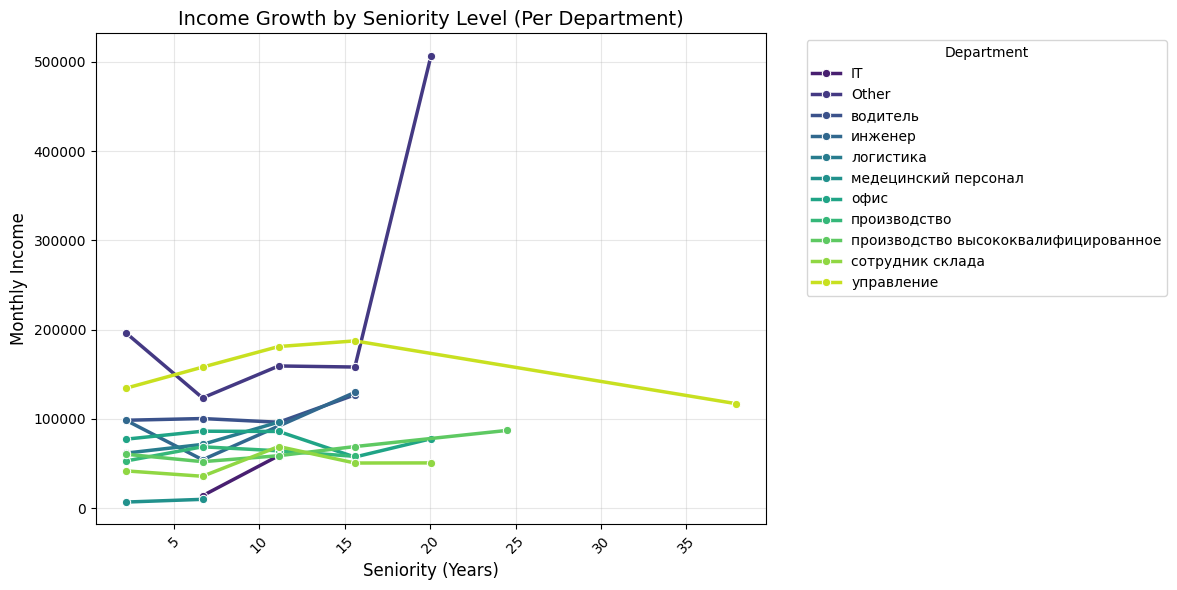

In [97]:
# Lets make plot of seniority vs income per job category:
X['seniority_bin'] = pd.cut(X['seniority'], 
                            bins=np.linspace(0, X['seniority'].max(), 10),
                            include_lowest=True)

plot_data = X.groupby(['active_department', 'seniority_bin'])['income_shortterm'].mean().reset_index()
plot_data['seniority_mid'] = plot_data['seniority_bin'].apply(lambda x: x.mid)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=plot_data,
    x='seniority_mid',  # Use numeric midpoints
    y='income_shortterm',
    hue='active_department',
    palette='viridis',
    marker='o',
    linewidth=2.5
)
plt.title('Income Growth by Seniority Level (Per Department)', fontsize=14)
plt.xlabel('Seniority (Years)', fontsize=12)
plt.ylabel('Monthly Income', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend(title='Department', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()